# Report on Fast Forward Neural Network

by Ruijie Rao

### Library Import

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy.random import RandomState

### Data import

In [41]:
with open("downgesture_train.list", "r") as file:
    train_dir = file.read().splitlines()
with open("downgesture_test.list", "r") as file:
    test_dir = file.read().splitlines()

In [42]:
def convert_pgm(file_dir:str):
    result = np.array(Image.open(file_dir)).flatten()*(1/255)
    return result

In [43]:
X_train = np.array([convert_pgm(file_dir) for file_dir in train_dir])
X_test = np.array([convert_pgm(file_dir) for file_dir in test_dir])

In [44]:
y_train = np.array([int("down"in file_dir) for file_dir in train_dir])
y_test = np.array([int("down"in file_dir) for file_dir in test_dir])

### Data Prep

In [45]:
X_train = np.c_[np.ones((X_train.shape[0],1)),X_train[:,:]]
X_test = np.c_[np.ones((X_test.shape[0],1)),X_test[:,:]]
rs = RandomState(0)

In [46]:
y_train

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

# Neural Network - Perceptron Learning

**Goal**: Use Multiple Perceptrons to accomplish more complex classifications.
1. Dynamic Programming for efficiently computing the gradient.
    - Storing the outputs of subproblems and avoid re-calculating.
2. Stochastic Gradient Descent

Iterations:
1. Compute $x^{(l)}_j$ for all $1\leq l \leq L$,$1\leq j \leq d^{(l)}$ in the forward direction:
$$
x^{(l)}_j = \theta(\sum_{i=0}^{d^{l-1}}w^{(l)}_{ij}x^{(l-1)}_i)
$$
2. Compute $\delta^{(l)}_i$ for all $1\leq l \leq L$,$1\leq i \leq d^{(l)}$ in the reverse direction:
$$
\delta^{(l-1)}_i = \theta(x^{(l-1)}_i)(1-\theta(x^{(l-1)}_i))(\sum_{j=0}^{d^{l-1}}w^{(l)}_{ij}\delta^{(l)}_j)
$$
Base case:
$$
\delta^{(L)}_i = 2(\theta(x^{(L)}_i)-y)\theta(x^{(l-1)}_i)(1-\theta(x^{(l-1)}_i))
$$
3. For each $w^{(l)}_{ij}$:
$$
w^{(l)}_{ij} = w^{(l)}_{ij}-\eta \delta^{(l)}_j x^{(l-1)}_i
$$

## Model Script

### Initialization

Will be using 1 hidden layer with a number of neurons equals to the mean of input and output neuron numbers.

In [8]:
def gen_d_list(Ni,No,Nn,Nh):
    d_list = [Nn for l in range(Nh)]
    d_list.insert(0,Ni)
    d_list.append(No)
    return d_list

def init_w(d_list):
    w_list = [rs.rand(d_list[i+1],d_list[i]) for i in range(len(d_list)-1)]
    w_list.insert(0,None)
    return w_list

### Loss Function

Going to use Mean Square Error as the Loss Function

In [9]:
def MSE(X,y,w):# X is NxD, w is 1xD, y is Nx1
    rss = np.sum(np.square(y-h(X,w)))
    mse = rss/len(X)
    return mse

### Gradient of Loss Function

Loss Function:$g = \frac{1}{N}\sum_{i=1}^{N}(h(x^{(i)})-y^{(i)})^2$

Where its partial derivative with respect to $j^{th} w$: $\frac{dg}{dw_j} = \frac{2}{N}\sum_{i=1}^{N}(h(x^{(i)})-y^{(i)})x^{(i)}_j$

In [10]:
def dMSE(X,y,w):
    m = len(X)
    d = len(X[0])
    dw = np.array([(2/m)*np.sum((h(X,w)-y)@X[:,j]) for j in range(d)])
    return dw

### Iteration Updates

In [18]:
class Neural_Network:
    def __init__(self,X,y,Nh=1,Nn=5):
        def gen_d_list(Ni,No,Nn,Nh):
            d_list = [Nn for l in range(Nh)]
            d_list.insert(0,Ni)
            d_list.append(No)
            return d_list

        def init_w(d_list):
            w_list = [(self.rs.rand(d_list[i+1],d_list[i])*0.02)-0.01 for i in range(len(d_list)-1)]
            w_list.insert(0,None)
            return w_list
        self.theta = lambda x: 1/(1+np.exp(-x))
        self.m = X.shape[0]
        self.rs = RandomState(2022)
        self.L = Nh+1
        self.d = X.shape[1]
        Ni = self.d # Number of Neurons in input layer
        No = 1 # Number of Neurons in output layer
        self.d_list = gen_d_list(Ni,No,Nn,Nh)
        self.X = X
        self.y = y

    def dsigmoid(self,x):
        return self.theta(x)*(1-self.theta(x))
        
    def update_x(self,x_in): # Compute all x in forward direction
        x_list= [x_in.reshape(1,self.d)]
        for l in range(1,self.L+1):
            z = x_list[l-1]@self.w_list[l].T # each x array should be 1xdi, w should be djxdi
            hx = self.theta(z)
            x_list.append(hx)
        return x_list # output list of 1xdj
    
    
    def update_delta(self,y_in,x_list): # Compute all delta in backward direction
        delta_list = [0 for i in x_list]
        delta_list[-1] = 2*(x_list[-1]-y_in)*self.dsigmoid(x_list[-1])
        for l in reversed(range(1,self.L+1)):
            delta = self.dsigmoid(x_list[l-1])*(delta_list[l]@self.w_list[l]) # delta should be 1xdj, w should be djxdi, result 1xdi
            delta_list[l-1] = delta
        return delta_list # output list of 1xdi
    
    def update_w(self,x_list,delta_list,alpha): # Update w
        for l in range(1,self.L+1):
            w = self.w_list[l] # djxdj
            x = x_list[l-1] # 1xdi
            delta = delta_list[l] # 1xdj
            w = w-alpha*(delta.T*x)
            self.w_list[l] = w
    
    def predict(self,X):
        hx = X
        for l in range(1,self.L+1):
            z = hx@self.w_list[l].T # X should be mxdi, w should be djxdi, result mxdj
            hx = self.theta(z)
        pred = np.array([0+int(p>=0.5) for p in hx])
        return pred
    
    def loss(self,X,y):
        loss = np.sum(np.square(y-self.predict(X)))/self.m
        return loss
    
    def plot_loss(self,loss_list):
        ax = plt.gca()
        ax.set_title('Loss')
        ax.plot(np.arange(len(loss_list)),loss_list)
        plt.show()
    
    def fit(self,alpha,epoch=1000):
        self.w_list = init_w(self.d_list)
        self.loss_list = []
        for e in range(epoch):
            for i in range(self.m):
                random_p = self.rs.randint(0,self.m-1)
                x_in = self.X[random_p] # random x point
                y_in = self.y[random_p]
                x_list = self.update_x(x_in)
                delta_list = self.update_delta(y_in,x_list)
                self.update_w(x_list,delta_list,alpha)
            current_loss = self.loss(self.X,self.y)
            if e%50==0:
                #print(self.predict())
                print(f"Epoch:{e+1}, Loss:{current_loss}")
            self.loss_list.append(current_loss)
        self.plot_loss(self.loss_list)
        return self.w_list

### Test

In [19]:
my_NN = Neural_Network(X_train,y_train,Nh=1,Nn=100)

Epoch:1, Loss:0.7336956521739131
Epoch:51, Loss:0.266304347826087
Epoch:101, Loss:0.2391304347826087
Epoch:151, Loss:0.25
Epoch:201, Loss:0.125
Epoch:251, Loss:0.11413043478260869
Epoch:301, Loss:0.125
Epoch:351, Loss:0.125
Epoch:401, Loss:0.07065217391304347
Epoch:451, Loss:0.016304347826086956
Epoch:501, Loss:0.021739130434782608
Epoch:551, Loss:0.0
Epoch:601, Loss:0.005434782608695652
Epoch:651, Loss:0.0
Epoch:701, Loss:0.0
Epoch:751, Loss:0.0
Epoch:801, Loss:0.0
Epoch:851, Loss:0.0
Epoch:901, Loss:0.0
Epoch:951, Loss:0.0


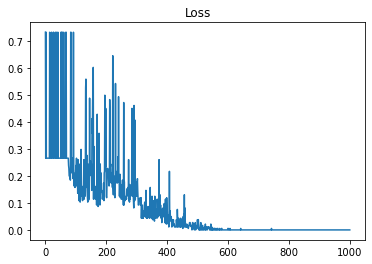

In [40]:
w = my_NN.fit(alpha=1e-1,epoch=1000)

In [41]:
my_NN.loss(X_test,y_test)

0.05434782608695652

In [44]:
pred = my_NN.predict(X_test)
sum(y_test==pred)/len(y_test)

0.8795180722891566

# Data Structure, Challenges, Optimizations

## Data Structure

X data is an array shaped of (m,d), where m is the number of PGM images, d is the number of pixels in each image. PGM images are read by PIL library and converted into numpy array. Then, the values are computed and changed into a range of (0,1) which is greyscale. Finally, a column of 1 is added to the data.

Y data is an array of 0 or 1 describing the image is down gesture or not.

W list is a list of weights arrays, which are of different shapes. The first layer of the list is None type, because layer 0 is not computed.

## Challenges

At first, I was copying the NN algorithm from last homework directly. However, the results were all wrong and I tried to look for what is going wrong. Soon, I figured out that the formula of update delta need to change since theta has changed from tanh to sigmoid in this problem.

## Optimizations

### Pocket Algorithm

By butting the best solution in the pocket during stochastic GD.In this assignment, the best weight of the last epoch will be used at the start of the next epoch,so that accuracy during the fit will not fluctuate that much.

Moreover, I have changed the loss calculation to calculating test set instead of training set, which should influence the pocket algorithm.

In [215]:
def pocket(w,w_best,acc,acc_best):
    if acc>acc_best:
        w_best = w
        acc_best = acc
    return w_best, acc_best

In [28]:
class Neural_Network_Pocket:
    def __init__(self,X,y,Nh=1,Nn=5):
        def gen_d_list(Ni,No,Nn,Nh):
            d_list = [Nn for l in range(Nh)]
            d_list.insert(0,Ni)
            d_list.append(No)
            return d_list

        def init_w(d_list):
            w_list = [(self.rs.rand(d_list[i+1],d_list[i])*0.02)-0.01 for i in range(len(d_list)-1)]
            w_list.insert(0,None)
            return w_list
        self.theta = lambda x: 1/(1+np.exp(-x))
        self.m = X.shape[0]
        self.rs = RandomState(2022)
        self.L = Nh+1
        self.d = X.shape[1]
        Ni = self.d # Number of Neurons in input layer
        No = 1 # Number of Neurons in output layer
        self.d_list = gen_d_list(Ni,No,Nn,Nh)
        self.X = X
        self.y = y

    def dsigmoid(self,x):
        return self.theta(x)*(1-self.theta(x))
        
    def update_x(self,x_in): # Compute all x in forward direction
        x_list= [x_in.reshape(1,self.d)]
        for l in range(1,self.L+1):
            z = x_list[l-1]@self.w_list[l].T # each x array should be 1xdi, w should be djxdi
            hx = self.theta(z)
            x_list.append(hx)
        return x_list # output list of 1xdj
    
    
    def update_delta(self,y_in,x_list): # Compute all delta in backward direction
        delta_list = [0 for i in x_list]
        delta_list[-1] = 2*(x_list[-1]-y_in)*self.dsigmoid(x_list[-1])
        for l in reversed(range(1,self.L+1)):
            delta = self.dsigmoid(x_list[l-1])*(delta_list[l]@self.w_list[l]) # delta should be 1xdj, w should be djxdi, result 1xdi
            delta_list[l-1] = delta
        return delta_list # output list of 1xdi
    
    def update_w(self,x_list,delta_list,alpha): # Update w
        for l in range(1,self.L+1):
            w = self.w_list[l] # djxdj
            x = x_list[l-1] # 1xdi
            delta = delta_list[l] # 1xdj
            w = w-alpha*(delta.T*x)
            self.w_list[l] = w
    
    def predict(self,X):
        hx = X
        for l in range(1,self.L+1):
            z = hx@self.w_list[l].T # X should be mxdi, w should be djxdi, result mxdj
            hx = self.theta(z)
        pred = np.array([0+int(p>=0.5) for p in hx])
        return pred
    
    def loss(self,X,y):
        loss = np.sum(np.square(y-self.predict(X)))/self.m
        return loss
    
    def plot_loss(self,loss_list):
        ax = plt.gca()
        ax.set_title('Loss')
        ax.plot(np.arange(len(loss_list)),loss_list)
        plt.show()
    
    def pocket(self):
        if self.acc>self.acc_best:
            self.w_best = self.w_list
            self.acc_best = self.acc
    
    def fit(self,alpha,epoch=1000):
        self.w_list = init_w(self.d_list)
        self.loss_list = []
        self.best_w = None
        self.best_loss = np.inf
        for e in range(epoch):
            for i in range(self.m):
                random_p = self.rs.randint(0,self.m-1)
                x_in = self.X[random_p] # random x point
                y_in = self.y[random_p]
                x_list = self.update_x(x_in)
                delta_list = self.update_delta(y_in,x_list)
                self.update_w(x_list,delta_list,alpha)
                current_loss = self.loss(X_test,y_test)
                if current_loss<self.best_loss:
                    self.best_loss = current_loss
                    self.best_w = self.w_list
            self.w_list = self.best_w
            if e%50==0:
                #print(self.predict())
                print(f"Epoch:{e+1}, Loss:{self.best_loss}")
            self.loss_list.append(self.best_loss)
        self.plot_loss(self.loss_list)
        return self.w_list

class Neural_Network_HeavyBall:
    def __init__(self,X,y,Nh=1,Nn=5):
        def gen_d_list(Ni,No,Nn,Nh):
            d_list = [Nn for l in range(Nh)]
            d_list.insert(0,Ni)
            d_list.append(No)
            return d_list

        def init_w(d_list):
            w_list = [(self.rs.rand(d_list[i+1],d_list[i])*0.02)-0.01 for i in range(len(d_list)-1)]
            w_list.insert(0,None)
            return w_list
        self.theta = lambda x: 1/(1+np.exp(-x))
        self.m = X.shape[0]
        self.rs = RandomState(2022)
        self.L = Nh+1
        self.d = X.shape[1]
        Ni = self.d # Number of Neurons in input layer
        No = 1 # Number of Neurons in output layer
        self.d_list = gen_d_list(Ni,No,Nn,Nh)
        self.X = X
        self.y = y

    def dsigmoid(self,x):
        return self.theta(x)*(1-self.theta(x))
        
    def update_x(self,x_in): # Compute all x in forward direction
        x_list= [x_in.reshape(1,self.d)]
        for l in range(1,self.L+1):
            z = x_list[l-1]@self.w_list[l].T # each x array should be 1xdi, w should be djxdi
            hx = self.theta(z)
            x_list.append(hx)
        return x_list # output list of 1xdj
    
    
    def update_delta(self,y_in,x_list): # Compute all delta in backward direction
        delta_list = [0 for i in x_list]
        delta_list[-1] = 2*(x_list[-1]-y_in)*self.dsigmoid(x_list[-1])
        for l in reversed(range(1,self.L+1)):
            delta = self.dsigmoid(x_list[l-1])*(delta_list[l]@self.w_list[l]) # delta should be 1xdj, w should be djxdi, result 1xdi
            delta_list[l-1] = delta
        return delta_list # output list of 1xdi
    
    def update_w(self,x_list,delta_list,p_list,alpha,beta): # Update w
        for l in range(1,self.L+1):
            w = self.w_list[l] # djxdj
            x = x_list[l-1] # 1xdi
            p = p_list[l]
            delta = delta_list[l] # 1xdj
            p = -alpha*(delta.T*x)+beta*p
            w = w+p
            self.w_list[l] = w
    
    def predict(self,X):
        hx = X
        for l in range(1,self.L+1):
            z = hx@self.w_list[l].T # X should be mxdi, w should be djxdi, result mxdj
            hx = self.theta(z)
        pred = np.array([0+int(p>=0.5) for p in hx])
        return pred
    
    def loss(self,X,y):
        loss = np.sum(np.square(y-self.predict(X)))/self.m
        return loss
    
    def plot_loss(self,loss_list):
        ax = plt.gca()
        ax.set_title('Loss')
        ax.plot(np.arange(len(loss_list)),loss_list)
        plt.show()
    
    def pocket(self):
        if self.acc>self.acc_best:
            self.w_best = self.w_list
            self.acc_best = self.acc
    
    def fit(self,alpha,beta=0.2,epoch=1000):
        self.w_list = init_w(self.d_list)
        self.loss_list = []
        self.best_w = None
        self.best_loss = np.inf
        for e in range(epoch):
            p_list = [0 for i in self.w_list]
            for i in range(self.m):
                random_p = self.rs.randint(0,self.m-1)
                x_in = self.X[random_p] # random x point
                y_in = self.y[random_p]
                x_list = self.update_x(x_in)
                delta_list = self.update_delta(y_in,x_list)
                self.update_w(x_list,delta_list,p_list,alpha,beta)
                current_loss = self.loss(X_test,y_test)
                if current_loss<self.best_loss:
                    self.best_loss = current_loss
                    self.best_w = self.w_list
            self.w_list = self.best_w
            if e%50==0:
                #print(self.predict())
                print(f"Epoch:{e+1}, Loss:{self.best_loss}")
            self.loss_list.append(self.best_loss)
        self.plot_loss(self.loss_list)
        return self.w_list

In [29]:
my_NN_pocket = Neural_Network_Pocket(X_train,y_train,Nh=1,Nn=100)

Epoch:1, Loss:0.10326086956521739
Epoch:51, Loss:0.10326086956521739
Epoch:101, Loss:0.07608695652173914


C:\Users\ruiji\AppData\Local\Temp/ipykernel_17252/2999349955.py:13: RuntimeWarning: overflow encountered in exp
  self.theta = lambda x: 1/(1+np.exp(-x))


Epoch:151, Loss:0.05434782608695652
Epoch:201, Loss:0.043478260869565216
Epoch:251, Loss:0.043478260869565216
Epoch:301, Loss:0.043478260869565216
Epoch:351, Loss:0.03804347826086957
Epoch:401, Loss:0.021739130434782608
Epoch:451, Loss:0.021739130434782608
Epoch:501, Loss:0.021739130434782608
Epoch:551, Loss:0.021739130434782608
Epoch:601, Loss:0.021739130434782608
Epoch:651, Loss:0.021739130434782608
Epoch:701, Loss:0.021739130434782608
Epoch:751, Loss:0.021739130434782608
Epoch:801, Loss:0.021739130434782608
Epoch:851, Loss:0.021739130434782608
Epoch:901, Loss:0.021739130434782608
Epoch:951, Loss:0.021739130434782608


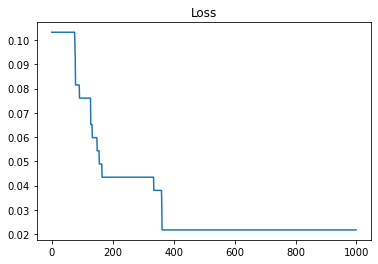

[None,
 array([[-3.93429413,  0.22188065, -0.25597181, ..., -0.16694019,
         -0.19681044,  0.39793082],
        [ 5.01085751,  0.17530102, -0.22583496, ..., -0.53740654,
         -0.82081462, -0.35975643],
        [ 2.10201816, -0.2873033 ,  0.39469028, ..., -0.13227369,
          0.37409951,  0.28554382],
        ...,
        [-5.12528733, -0.4836181 , -0.12285077, ..., -0.56322968,
         -0.25528401,  0.43731052],
        [-3.20086322,  0.04773226, -0.04309797, ..., -0.26798285,
         -0.32439349, -0.46770454],
        [ 4.22818687, -0.19570363, -0.08724987, ..., -0.31207436,
         -0.29198809, -0.29799917]]),
 array([[ 2.2609612 ,  1.8584726 ,  1.52759858, -1.15612649,  1.63114621,
          1.78153097,  1.6819914 ,  2.3790865 ,  1.74397238,  1.78813971,
          2.20273842,  0.13972361, -1.55220971, -2.61854517,  0.36970859,
          2.14784874, -3.55663536, -3.95391637,  1.52128951, -0.89413009,
          2.12809623,  1.88349883,  1.97634323,  1.31338364,  1.683555

In [30]:
my_NN_pocket.fit(alpha=1e-1,epoch=1000)

In [31]:
pred = my_NN_pocket.predict(X_test)
sum(y_test==pred)/len(y_test)

C:\Users\ruiji\AppData\Local\Temp/ipykernel_17252/2999349955.py:13: RuntimeWarning: overflow encountered in exp
  self.theta = lambda x: 1/(1+np.exp(-x))


0.9036144578313253

Accuracy has raised and loss fluctuation has stabilized.

### Heavyball/Momentum

Heavyball algorithm works by increasing the momentum when GD is moving twds the right direction, and decreasing the momentum on the other hand. 
$$
p_k = \delta^{(l)}_j x^{(l-1)}_i \\
w^{(l)}_{ij} = w^{(l)}_{ij}-\eta p_k+\beta p_{k-1}
$$

In [34]:
my_NN_hb = Neural_Network_HeavyBall(X_train,y_train,Nh=1,Nn=100)

Epoch:1, Loss:0.10326086956521739
Epoch:51, Loss:0.10326086956521739
Epoch:101, Loss:0.08152173913043478


C:\Users\ruiji\AppData\Local\Temp/ipykernel_17252/949553836.py:13: RuntimeWarning: overflow encountered in exp
  self.theta = lambda x: 1/(1+np.exp(-x))


Epoch:151, Loss:0.043478260869565216
Epoch:201, Loss:0.043478260869565216
Epoch:251, Loss:0.03804347826086957
Epoch:301, Loss:0.03804347826086957
Epoch:351, Loss:0.03804347826086957
Epoch:401, Loss:0.03804347826086957
Epoch:451, Loss:0.03804347826086957
Epoch:501, Loss:0.03260869565217391
Epoch:551, Loss:0.03260869565217391
Epoch:601, Loss:0.03260869565217391
Epoch:651, Loss:0.03260869565217391
Epoch:701, Loss:0.02717391304347826
Epoch:751, Loss:0.021739130434782608
Epoch:801, Loss:0.016304347826086956
Epoch:851, Loss:0.016304347826086956
Epoch:901, Loss:0.016304347826086956
Epoch:951, Loss:0.016304347826086956


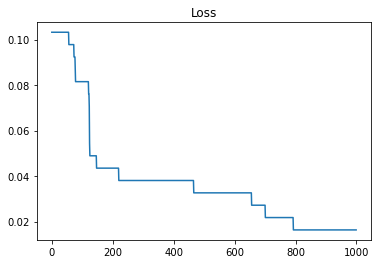

[None,
 array([[ 0.86718058,  0.29529779,  0.86228808, ...,  0.1567525 ,
          0.25631394, -0.04701554],
        [-0.49487336,  0.02912094, -0.21592381, ...,  0.39948672,
          1.02029142,  0.48245466],
        [ 2.30648691,  0.04753675, -0.08333212, ...,  0.95806218,
          0.37942808,  0.46786333],
        ...,
        [-3.95507897, -0.18705484,  0.21006979, ..., -0.66926504,
         -0.29793114,  0.05657624],
        [-3.77231724, -0.48678279, -0.48567117, ..., -0.43607202,
         -0.2993626 ,  0.05876564],
        [ 1.08920794,  0.66957683, -0.20146079, ...,  0.96833632,
          0.90545593,  1.68873277]]),
 array([[ 6.41589882e-01, -5.42687092e-01,  2.09751630e+00,
         -9.66293842e-01,  2.62468899e+00,  6.36161030e-01,
          3.83344546e+00, -2.80636730e+00,  1.23241455e-01,
          2.48025569e-01,  6.02157138e-02,  3.25409235e+00,
         -4.63949350e+00,  8.67081282e-01,  1.76931888e+00,
          2.88242172e-01,  6.90842421e-01, -1.16981863e-01,
      

In [36]:
my_NN_hb.fit(alpha=1e-1,beta=0.4,epoch=1000)

In [37]:
pred = my_NN_hb.predict(X_test)
sum(y_test==pred)/len(y_test)

C:\Users\ruiji\AppData\Local\Temp/ipykernel_17252/949553836.py:13: RuntimeWarning: overflow encountered in exp
  self.theta = lambda x: 1/(1+np.exp(-x))


0.9397590361445783

Accuracy has been raised again.